# Iteratively learning classifier weights vs computing Fisher linear discriminant

## Question 1:

#### How many epochs you need to train iteratively to achieve similar accuracy to Fisher LDA? What controls a number of epochs?

## Question 2:

#### What happens if you increase learning rate and what happens if you decrease learning rate?

## Question 3:

#### For this dataset change the covariance matrix into identity matrix. How the data changed? compute Fisher's discriminant when covariance matrix is identity matrix [[1,0][0,1]]. In this case what accuracy you obtain with iterative algorithm ? In Fisher discriminant what determines the values of weights W now? In what class data configuration such linear discriminant is most effective?  

## Iterative search 
FC book ch 3.

#### Generating two classes of random points in a 2D plane (Listing 3.13 - 3.16)

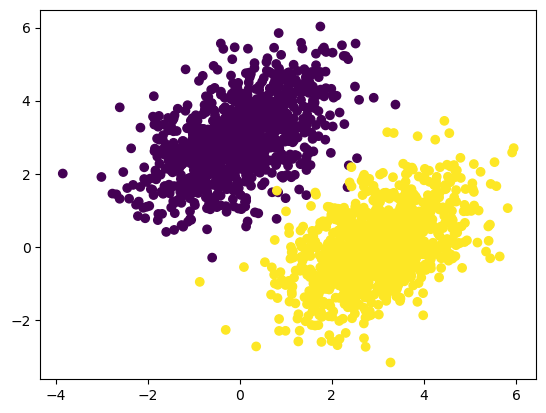

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Generate
num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(mean=[0, 3], cov=[[1, 0.5],[0.5, 1]], size=num_samples_per_class)
positive_samples = np.random.multivariate_normal(mean=[3, 0],cov=[[1, 0.5],[0.5, 1]],size=num_samples_per_class)

# Stack
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)

# Labels
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                     np.ones((num_samples_per_class, 1), dtype="float32")))

# Visualize

plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()


#### Creating the linear classifier variables

In [8]:
input_dim = 2
output_dim = 1
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

#### The forward pass function

In [9]:
def model(inputs):
    return tf.matmul(inputs, W) + b

Because our linear classifier operates on 2D inputs, W is really just two scalar coeffi-
cients, w1 and w2: W = [[w1], [w2]]. Meanwhile, b is a single scalar coefficient. As such,
for a given input point [x, y], its prediction value is prediction = [[w1], [w2]] • [x,
y] + b = w1 * x + w2 * y + b.

#### The mean squared error loss function

In [10]:
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_losses)

#### The training step function

In [11]:
learning_rate = 0.1
# Retrieve the gradient of the loss with regardto weights.
def training_step(inputs, targets):
    with tf.GradientTape() as tape:
        # Forward pass, inside a gradient tape scope
        predictions = model(inputs)
        loss = square_loss(predictions, targets)
    
    # Update the weights.
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    W.assign_sub(grad_loss_wrt_W * learning_rate)
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

#### The batch training loop

In [12]:
for step in range(20):
    loss = training_step(inputs, targets)
    print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 6.6720
Loss at step 1: 0.7603
Loss at step 2: 0.2283
Loss at step 3: 0.1592
Loss at step 4: 0.1417
Loss at step 5: 0.1308
Loss at step 6: 0.1213
Loss at step 7: 0.1128
Loss at step 8: 0.1050
Loss at step 9: 0.0979
Loss at step 10: 0.0915
Loss at step 11: 0.0856
Loss at step 12: 0.0802
Loss at step 13: 0.0754
Loss at step 14: 0.0709
Loss at step 15: 0.0669
Loss at step 16: 0.0632
Loss at step 17: 0.0598
Loss at step 18: 0.0567
Loss at step 19: 0.0539


#### Plot the results

Recall that the prediction value for a given point [x, y] is simply prediction ==[[w1], [w2]] • [x, y] + b == w1 * x + w2 * y + b. 

Thus, class 0 is defined as w1 * x + w2 * y + b < 0.5, and class 1 is defined as w1 * x + w2 * y + b > 0.5. You’ll notice that what you’re looking at is really the equation of a line in the 2D plane: w1 * x + w2 * y + b = 0.5.

Above the line is class 1, and below the line is class 0. You may be used to seeing line
equations in the format y = a * x + b; in the same format, our line becomes y = - w1 / w2 * x + (0.5 - b) / w2.

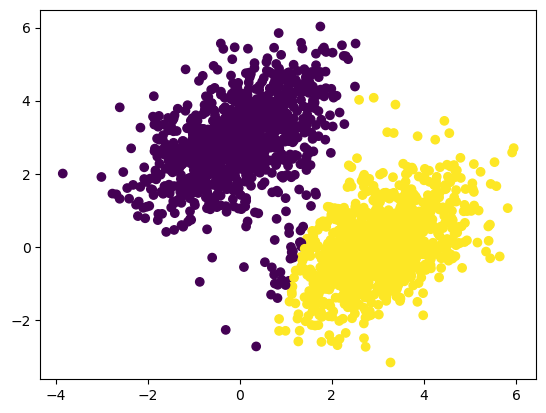

In [13]:
predictions = model(inputs)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

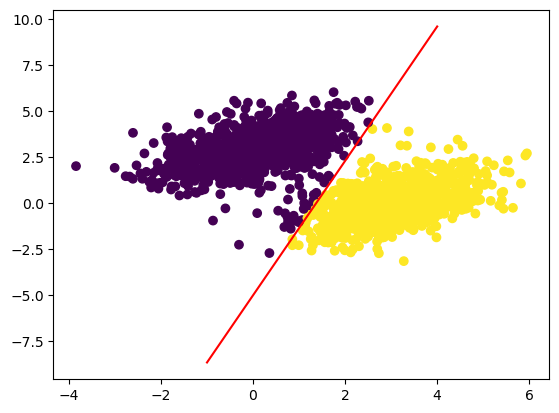

In [14]:
x = np.linspace(-1, 4, 100)
y = - W[0] / W[1] * x + (0.5 - b) / W[1]

plt.plot(x, y, "-r")
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)

#### Train less and see how line is not in the right position ; crosstabulate predictions and targets

In [15]:
print(predictions)

tf.Tensor(
[[ 0.14073533]
 [-0.01676217]
 [-0.36359888]
 ...
 [ 0.8236799 ]
 [ 1.0305659 ]
 [ 0.84023964]], shape=(2000, 1), dtype=float32)


In [32]:
tf.math.confusion_matrix(targets, predictions[:,0] > 0.5)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[994,   6],
       [ 35, 965]], dtype=int32)>

## Fisher linear discriminant

Recall from Duda and Heart "Pattern Classification" formula of optimal direction separating classes: inverse covariance matrix multiplied by difference in means computed from data.   

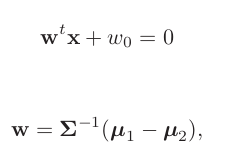

#### Compute the discriminant

In [37]:
mu_negative, mu_positive = negative_samples.mean(axis=0).reshape(-1,1), positive_samples.mean(axis=0).reshape(-1,1)
Sw = np.cov(positive_samples.T) + np.cov(negative_samples.T)
inv_S = np.linalg.inv(Sw)
WFisher = inv_S.dot(mu_positive-mu_negative) 
bFisher=[0]

print(WFisher)
print(bFisher)

[[ 3.00744971]
 [-2.91915043]]
[0]


#### Plot decision boundaries

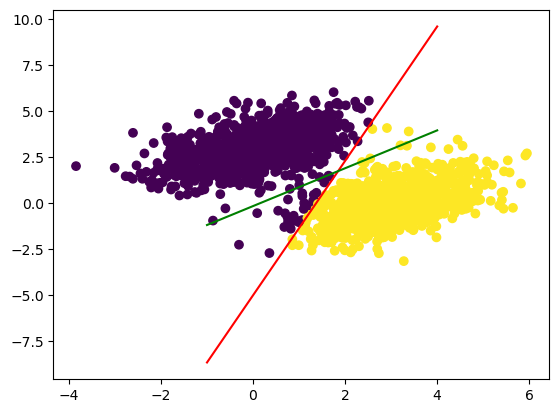

In [38]:
x = np.linspace(-1, 4, 100)

y = - W[0] / W[1] * x + (0.5 - b) / W[1]
yFisher = - WFisher[0] / WFisher[1] * x + (0.5 - bFisher[0]) / WFisher[1]

plt.plot(x, y, "-r")
plt.plot(x, yFisher, "-g")
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)

In [39]:
Fpredictions = inputs.dot(WFisher)
print(Fpredictions)

[[ -7.80167708]
 [-10.00245207]
 [-12.66242449]
 ...
 [ 10.03853547]
 [  7.19947872]
 [ 11.80692527]]


In [40]:
tf.math.confusion_matrix(targets, Fpredictions[:,0] > 0)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[995,   5],
       [  1, 999]], dtype=int32)>

In [ ]:
# May be needed later
# Normalize coefficients
#WFisher = WFisher/np.linalg.norm(WFisher)
# Compute b. The discriminant line is half way from mu. 
#m = (mu_positive.T-mu_negative.T)/2
# Normalize m
#m = m/np.linalg.norm(m)
#bFisher=-m.dot(WFisher)
